Install Important Libraries

In [ ]:
!pip install tensorflow opencv-python matplotlib numpy onnx tf2onnx tensorflow-addons scikit-learn scikit-image

In [ ]:
from google.colab import files
uploaded = files.upload()  # Upload "IRIS+PUPIL+EYE.zip"

Saving pupil-eye-and-iris-segmentation.zip to pupil-eye-and-iris-segmentation (2).zip


In [ ]:
!pip install --upgrade tensorflow
!pip install --upgrade jax jaxlib  # Only if you need JAX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 124.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.10.6 requires jax>=0.5.1, which is not installed.
orbax-checkpoint 0.11.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 90.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 MB 9.2 MB/s eta 0:00:00


In [ ]:
import zipfile
import os

# Extract the ZIP file
with zipfile.ZipFile('pupil-eye-and-iris-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Verify the extracted files
print("Extracted files:")
!ls -R dataset/

Extracted files:
dataset/:
'IRIS + PUPIL + EYE'

'dataset/IRIS + PUPIL + EYE':
train  val

'dataset/IRIS + PUPIL + EYE/train':
image  segmentation

'dataset/IRIS + PUPIL + EYE/train/image':
0213_2_1_2_53_006.png  0235_2_1_2_52_004.png  0257_2_1_2_53_002.png
0214_1_1_2_20_003.png  0236_1_1_2_20_001.png  0257_2_1_2_53_006.png
0214_1_1_2_32_001.png  0236_1_1_2_21_000.png  0258_1_1_2_20_001.png
0214_1_1_2_32_003.png  0236_1_1_2_21_005.png  0258_1_1_2_21_003.png
0214_1_1_2_34_002.png  0236_1_1_2_22_003.png  0258_1_1_2_22_001.png
0214_1_1_2_52_003.png  0236_1_1_2_23_000.png  0258_1_1_2_23_004.png
0214_1_1_2_53_001.png  0236_1_1_2_34_000.png  0258_1_1_2_32_000.png
0214_2_1_2_20_000.png  0236_1_1_2_51_005.png  0258_1_1_2_32_001.png
0214_2_1_2_24_002.png  0236_2_1_2_22_003.png  0258_1_1_2_32_003.png
0214_2_1_2_31_001.png  0236_2_1_2_23_002.png  0258_1_1_2_33_001.png
0214_2_1_2_31_004.png  0236_2_1_2_32_005.png  0258_1_1_2_34_004.png
0214_2_1_2_33_003.png  0236_2_1_2_34_000.png  0258_1_1_2_51_00

In [ ]:
import os
import cv2
import numpy as np

def load_data(base_path, img_size=(256, 256)):
    # Training data
    train_img_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'train', 'image')
    train_mask_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'train', 'segmentation')

    # Validation data
    val_img_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'val', 'image')
    val_mask_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'val', 'segmentation')

    def load_images_and_masks(img_dir, mask_dir):
        images, masks = [], []
        img_names = sorted(os.listdir(img_dir))

        for img_name in img_names:
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Skipping file: {img_name} due to load failure")
                continue

            # Resize & normalize
            img = cv2.resize(img, img_size) / 255.0
            mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

            # Convert mask to binary
            mask = np.where(mask > 127, 1, 0)

            images.append(img)
            masks.append(mask)

        return np.array(images), np.array(masks)

    X_train, y_train = load_images_and_masks(train_img_dir, train_mask_dir)
    X_val, y_val = load_images_and_masks(val_img_dir, val_mask_dir)

    return X_train, y_train, X_val, y_val


In [ ]:
def plot_sample(X, y, n=3):
    plt.figure(figsize=(4 * n, 8))
    for i in range(n):
        # Image
        plt.subplot(2, n, i+1)
        plt.imshow(X[i])
        plt.title(f'Image {i}')
        plt.axis('off')

        # Corresponding mask
        plt.subplot(2, n, i+1+n)
        plt.imshow(y[i], cmap='gray')
        plt.title(f'Mask {i}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
import os
print([f for f in os.listdir('.') if 'jax' in f])


[]


In [ ]:
pip uninstall jax jaxlib -y


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import Model

def unet_multiclass(input_size=(256, 256, 3), num_classes=4):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)

    # Decoder
    up5 = UpSampling2D(size=(2, 2))(drop4)
    up5 = Conv2D(256, 2, activation='relu', padding='same')(up5)
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(merge5)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(128, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(64, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)

    # Output layer for 4-class segmentation
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv7)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create model
model = unet_multiclass()

# Use sparse_categorical_crossentropy if your masks have integer class labels (0,1,2,3)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 64, 64,    │          0 │ dropout[0][0]     │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 64, 64,    │    524,544 │ up_sampling2d[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 512)              │            │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0

 Total params: 7,697,540 (29.36 MB)

 Trainable params: 7,697,540 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import os
import cv2
import numpy as np

def load_data(base_path, img_size=(256, 256)):
    # Paths
    train_img_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'train', 'image')
    train_mask_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'train', 'segmentation')

    val_img_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'val', 'image')
    val_mask_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'val', 'segmentation')

    def load_images_and_masks(img_dir, mask_dir):
        images, masks = []
        img_names = sorted(os.listdir(img_dir))

        for img_name in img_names:
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Skipping file: {img_name} due to load failure")
                continue

            try:
                # Resize image and normalize
                img = cv2.resize(img, img_size) / 255.0

                # Resize mask with nearest neighbor to preserve label values
                mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

                # Ensure mask is integer and valid
                mask = mask.astype(np.uint8)

                # Optional: clamp labels to [0, 3] if needed
                mask = np.clip(mask, 0, 3)

                # Ensure image has 3 channels
                if img.ndim == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                if img.shape == (img_size[0], img_size[1], 3) and mask.shape == img_size:
                    images.append(img)
                    masks.append(mask)
                else:
                    print(f"Shape mismatch in file: {img_name}")
                    continue
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
                continue

        # Convert lists to numpy arrays
        images_np = np.array(images, dtype=np.float32)
        masks_np = np.array(masks, dtype=np.uint8)  # IMPORTANT: int labels for sparse_categorical_crossentropy

        print(f"Loaded {len(images)} images and {len(masks)} masks from {img_dir}")
        print(f"Image shape: {images_np.shape}, Mask shape: {masks_np.shape}")
        print(f"Unique labels in masks: {np.unique(masks_np)}")

        return images_np, masks_np

    X_train, y_train = load_images_and_masks(train_img_dir, train_mask_dir)
    X_val, y_val = load_images_and_masks(val_img_dir, val_mask_dir)

    return X_train, y_train, X_val, y_val


In [ ]:
import os
import cv2
import numpy as np

def load_data(base_path, img_size=(256, 256)):
    # Training data
    train_img_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'train', 'image')
    train_mask_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'train', 'segmentation')

    # Validation data
    val_img_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'val', 'image')
    val_mask_dir = os.path.join(base_path, 'IRIS + PUPIL + EYE', 'val', 'segmentation')

    def load_images_and_masks(img_dir, mask_dir):
        images, masks = [], []
        img_names = sorted(os.listdir(img_dir))

        for img_name in img_names:
            img_path = os.path.join(img_dir, img_name)
            mask_path = os.path.join(mask_dir, img_name)

            img = cv2.imread(img_path)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if img is None or mask is None:
                print(f"Skipping file: {img_name} due to load failure")
                continue

            try:
                # Resize & normalize image
                img = cv2.resize(img, img_size).astype(np.float32) / 255.0
                if img.shape[2] == 4:
                    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
                elif len(img.shape) == 2:
                    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

                # Resize mask (nearest neighbor to preserve labels)
                mask = cv2.resize(mask, img_size, interpolation=cv2.INTER_NEAREST)

                # Make sure mask values are in [0, 3]
                mask = np.clip(mask, 0, 3).astype(np.uint8)

                if img.shape == (img_size[0], img_size[1], 3) and mask.shape == img_size:
                    images.append(img)
                    masks.append(mask)
                else:
                    print(f"Skipping file: {img_name} due to shape mismatch")

            except Exception as e:
                print(f"Error processing file {img_name}: {e}")
                continue

        images_np = np.array(images, dtype=np.float32)
        masks_np = np.array(masks, dtype=np.uint8)  # no expand_dims

        print(f"Loaded {len(images)} images and {len(masks)} masks from {img_dir}")
        print(f"Image shape: {images_np.shape}, Mask shape: {masks_np.shape}")
        print(f"Unique labels in masks: {np.unique(masks_np)}")

        return images_np, masks_np

    X_train, y_train = load_images_and_masks(train_img_dir, train_mask_dir)
    X_val, y_val = load_images_and_masks(val_img_dir, val_mask_dir)

    return X_train, y_train, X_val, y_val

# Load data
base_data_path = 'dataset'
X_train, y_train, X_val, y_val = load_data(base_data_path)


Skipping file: desktop.ini due to load failure
Loaded 1000 images and 1000 masks from dataset/IRIS + PUPIL + EYE/train/image
Image shape: (1000, 256, 256, 3), Mask shape: (1000, 256, 256)
Unique labels in masks: [0 1 2 3]
Loaded 275 images and 275 masks from dataset/IRIS + PUPIL + EYE/val/image
Image shape: (275, 256, 256, 3), Mask shape: (275, 256, 256)
Unique labels in masks: [0 1 2 3]


In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


X_train shape: (1000, 256, 256, 3)
y_train shape: (1000, 256, 256)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    EarlyStopping(patience=10, verbose=1, restore_best_weights=True),
    ModelCheckpoint('unet_multiclass_best_model.h5', verbose=1, save_best_only=True, monitor='val_sparse_categorical_accuracy', mode='max')
]

history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50
125/125 - 141s - 1s/step - accuracy: 0.7250 - loss: 0.6825 - val_accuracy: 0.8108 - val_loss: 0.4484
Epoch 2/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 62s - 498ms/step - accuracy: 0.8465 - loss: 0.3622 - val_accuracy: 0.8889 - val_loss: 0.2869
Epoch 3/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 657ms/step - accuracy: 0.8817 - loss: 0.2941 - val_accuracy: 0.9062 - val_loss: 0.2424
Epoch 4/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 81s - 650ms/step - accuracy: 0.8987 - loss: 0.2559 - val_accuracy: 0.9102 - val_loss: 0.2331
Epoch 5/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 654ms/step - accuracy: 0.9180 - loss: 0.2093 - val_accuracy: 0.9138 - val_loss: 0.2276
Epoch 6/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 83s - 662ms/step - accuracy: 0.9275 - loss: 0.1852 - val_accuracy: 0.9316 - val_loss: 0.1748
Epoch 7/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 81s - 649ms/step - accuracy: 0.9401 - loss: 0.1526 - val_accuracy: 0.9249 - val_loss: 0.1840
Epoch 8/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 85s - 678ms/step - accuracy: 0.9446 - loss: 0.1392 - val_accuracy: 0.9397 - val_loss: 0.1489
Epoch 9/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 83s - 663ms/step - accuracy: 0.9479 - loss: 0.1290 - val_accuracy: 0.9400 - val_loss: 0.1467
Epoch 10/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 465ms/step - accuracy: 0.9499 - loss: 0.1232 - val_accuracy: 0.9422 - val_loss: 0.1397
Epoch 11/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 59s - 471ms/step - accuracy: 0.9512 - loss: 0.1201 - val_accuracy: 0.9426 - val_loss: 0.1471
Epoch 12/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 83s - 663ms/step - accuracy: 0.9544 - loss: 0.1121 - val_accuracy: 0.9408 - val_loss: 0.1542
Epoch 13/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 468ms/step - accuracy: 0.9564 - loss: 0.1068 - val_accuracy: 0.9342 - val_loss: 0.1653
Epoch 14/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 83s - 662ms/step - accuracy: 0.9580 - loss: 0.1021 - val_accuracy: 0.9421 - val_loss: 0.1463
Epoch 15/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 658ms/step - accuracy: 0.9582 - loss: 0.1018 - val_accuracy: 0.9431 - val_loss: 0.1572
Epoch 16/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 655ms/step - accuracy: 0.9603 - loss: 0.0964 - val_accuracy: 0.9459 - val_loss: 0.1408
Epoch 17/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 81s - 650ms/step - accuracy: 0.9618 - loss: 0.0922 - val_accuracy: 0.9417 - val_loss: 0.1493
Epoch 18/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 655ms/step - accuracy: 0.9612 - loss: 0.0942 - val_accuracy: 0.9458 - val_loss: 0.1406
Epoch 19/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 655ms/step - accuracy: 0.9632 - loss: 0.0886 - val_accuracy: 0.9457 - val_loss: 0.1420
Epoch 20/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 660ms/step - accuracy: 0.9616 - loss: 0.0935 - val_accuracy: 0.9453 - val_loss: 0.1373
Epoch 21/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 81s - 650ms/step - accuracy: 0.9637 - loss: 0.0878 - val_accuracy: 0.9444 - val_loss: 0.1446
Epoch 22/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 660ms/step - accuracy: 0.9643 - loss: 0.0863 - val_accuracy: 0.9473 - val_loss: 0.1497
Epoch 23/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 462ms/step - accuracy: 0.9659 - loss: 0.0822 - val_accuracy: 0.9466 - val_loss: 0.1430
Epoch 24/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 464ms/step - accuracy: 0.9676 - loss: 0.0778 - val_accuracy: 0.9474 - val_loss: 0.1436
Epoch 25/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 83s - 663ms/step - accuracy: 0.9691 - loss: 0.0735 - val_accuracy: 0.9458 - val_loss: 0.1532
Epoch 26/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 463ms/step - accuracy: 0.9693 - loss: 0.0731 - val_accuracy: 0.9494 - val_loss: 0.1363
Epoch 27/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 465ms/step - accuracy: 0.9660 - loss: 0.0822 - val_accuracy: 0.9432 - val_loss: 0.1641
Epoch 28/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 83s - 664ms/step - accuracy: 0.9690 - loss: 0.0743 - val_accuracy: 0.9473 - val_loss: 0.1409
Epoch 29/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 462ms/step - accuracy: 0.9708 - loss: 0.0698 - val_accuracy: 0.9473 - val_loss: 0.1584
Epoch 30/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 84s - 671ms/step - accuracy: 0.9720 - loss: 0.0671 - val_accuracy: 0.9462 - val_loss: 0.1854
Epoch 31/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 467ms/step - accuracy: 0.9728 - loss: 0.0646 - val_accuracy: 0.9447 - val_loss: 0.1781
Epoch 32/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 59s - 471ms/step - accuracy: 0.9732 - loss: 0.0638 - val_accuracy: 0.9454 - val_loss: 0.1912
Epoch 33/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 59s - 468ms/step - accuracy: 0.9724 - loss: 0.0659 - val_accuracy: 0.9466 - val_loss: 0.1608
Epoch 34/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 59s - 469ms/step - accuracy: 0.9730 - loss: 0.0644 - val_accuracy: 0.9474 - val_loss: 0.1668
Epoch 35/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 82s - 659ms/step - accuracy: 0.9746 - loss: 0.0603 - val_accuracy: 0.9472 - val_loss: 0.1768
Epoch 36/50


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


125/125 - 58s - 462ms/step - accuracy: 0.9731 - loss: 0.0642 - val_accuracy: 0.9476 - val_loss: 0.1732
Epoch 36: early stopping
Restoring model weights from the end of the best epoch: 26.


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_sparse_categorical_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [ ]:
model.save("unet_multiclass_final_model.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("unet_multiclass_final_model.h5", compile=False)


In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension: (1, 256, 256, 3)
    return img


In [ ]:
# Load and preprocess image
image_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_2_1_2_22_005.png"
input_img = preprocess_image(image_path)

# Predict
pred = model.predict(input_img)

# Convert softmax output to class label mask
pred_mask = np.argmax(pred[0], axis=-1)  # Shape: (256, 256), values: 0, 1, 2, 3


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


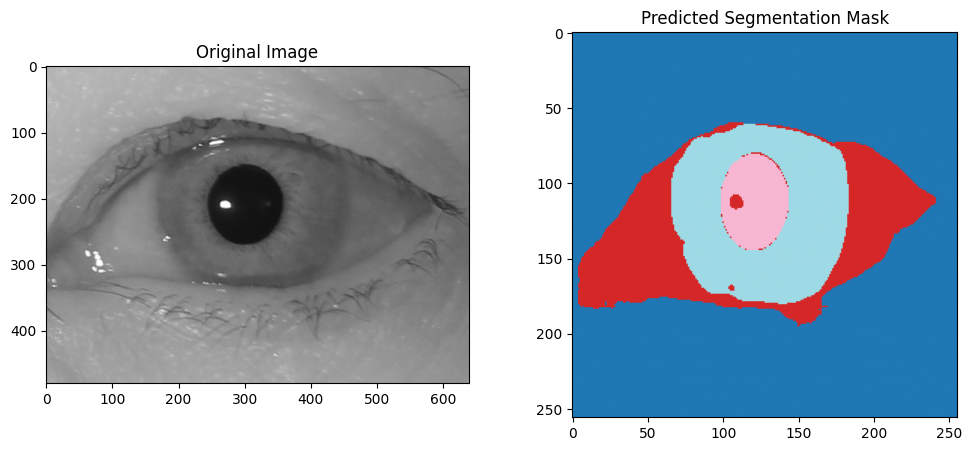

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.imread(image_path)[..., ::-1])  # Convert BGR to RGB
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(pred_mask, cmap='tab20')  # 4 classes in different colors
plt.title("Predicted Segmentation Mask")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


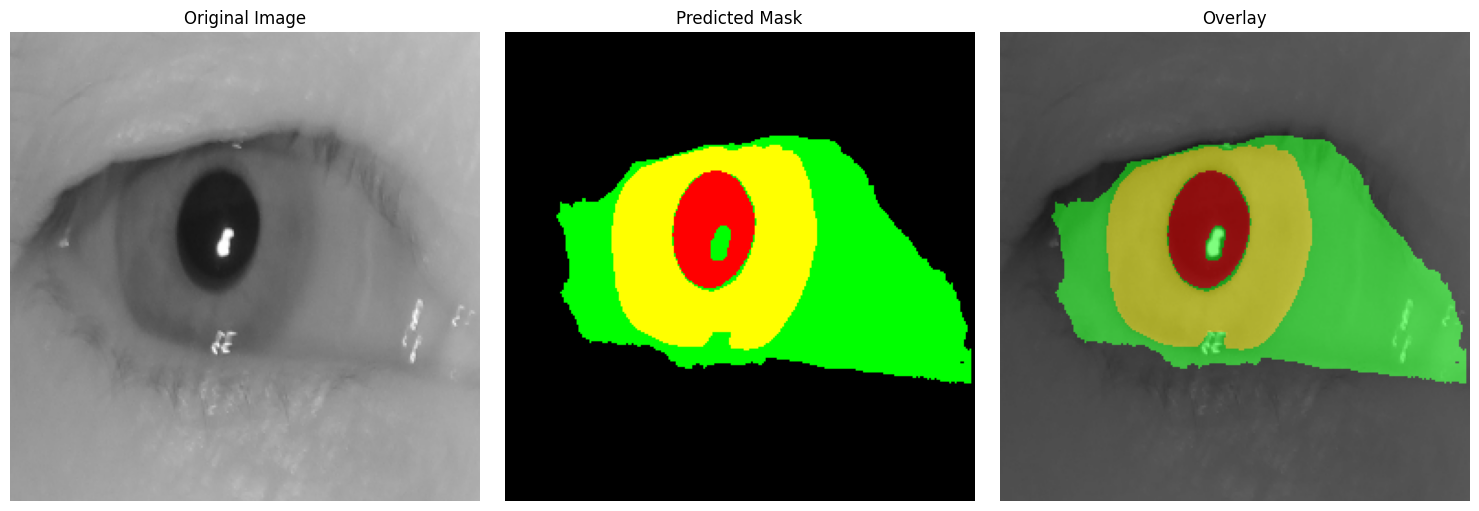

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load your trained model
model = load_model("unet_multiclass_final_model.h5")

# Define your class-to-color mapping (adjust colors as needed)
CLASS_COLORS = {
    0: (0, 0, 0),          # Background - black
    1: (0, 255, 0),        # Class 1 - green
    2: (255, 0, 0),        # Class 2 - blue
    3: (255, 255, 0)       # Class 3 - cyan
}

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess image for inference."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Shape: (1, H, W, 3)
    return img

def predict_mask(image_path):
    """Predict segmentation mask for a given image path."""
    img_input = preprocess_image(image_path)
    pred = model.predict(img_input)[0]  # Shape: (H, W, num_classes)
    pred_mask = np.argmax(pred, axis=-1)  # Shape: (H, W)
    return pred_mask

def decode_mask(mask):
    """Convert predicted mask (H, W) to RGB color mask."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

def overlay_mask_on_image(image_path, mask, alpha=0.5):
    """Overlay color mask on original image."""
    original = cv2.imread(image_path)
    original = cv2.resize(original, (256, 256))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    color_mask = decode_mask(mask)
    overlay = cv2.addWeighted(original_rgb, 1 - alpha, color_mask, alpha, 0)

    return original_rgb, color_mask, overlay

def predict_and_overlay(image_path):
    """Complete prediction and visualization pipeline."""
    pred_mask = predict_mask(image_path)
    original, color_mask, overlay = overlay_mask_on_image(image_path, pred_mask)

    # Display the result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(color_mask)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔥 Run inference on a sample image
predict_and_overlay("/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


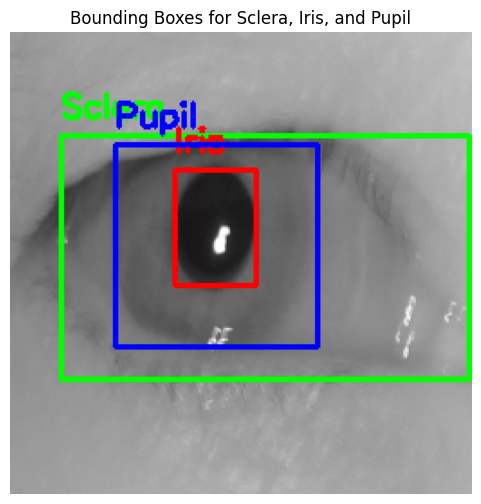

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("unet_multiclass_final_model.h5")

# Define class mapping and colors
label_map = {1: 'Sclera', 2: 'Iris', 3: 'Pupil'}
box_colors = {
    1: (0, 255, 0),     # Green for sclera
    2: (255, 0, 0),     # Blue for iris
    3: (0, 0, 255)      # Red for pupil
}

# Preprocess input image
def preprocess_image(image_path, target_size=(256, 256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # (1, H, W, 3)
    return img

# Predict mask
def predict_mask(image_path):
    img_input = preprocess_image(image_path)
    pred = model.predict(img_input)[0]  # (H, W, num_classes)
    pred_mask = np.argmax(pred, axis=-1).astype(np.uint8)  # (H, W)
    return pred_mask

# Main function to draw bounding boxes
def draw_bounding_boxes(image_path):
    pred_mask = predict_mask(image_path)

    # Resize original image to match prediction size
    original = cv2.imread(image_path)
    original_resized = cv2.resize(original, (256, 256))
    original_rgb = cv2.cvtColor(original_resized, cv2.COLOR_BGR2RGB)
    boxed_image = original_rgb.copy()

    for class_id in [1, 2, 3]:
        binary_mask = (pred_mask == class_id).astype(np.uint8) * 255

        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            x, y, w, h = cv2.boundingRect(largest_contour)

            # Draw bounding box
            cv2.rectangle(boxed_image, (x, y), (x + w, y + h), box_colors[class_id], 2)

            # Label
            cv2.putText(boxed_image, label_map[class_id], (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, box_colors[class_id], 2)

    # Show result
    plt.figure(figsize=(6, 6))
    plt.imshow(boxed_image)
    plt.title("Bounding Boxes for Sclera, Iris, and Pupil")
    plt.axis('off')
    plt.show()

# 🔥 Run on a sample image from your dataset
draw_bounding_boxes("/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png")


In [ ]:
import os

# List all files in current directory
for file in os.listdir():
    print(file)


.config
pupil-eye-and-iris-segmentation.zip
pupil-eye-and-iris-segmentation (1).zip
dataset
pupil-eye-and-iris-segmentation (2).zip
unet_multiclass_final_model.h5
sample_data


In [ ]:
pip install tf2onnx onnx


In [ ]:
pip install numpy==1.23.5 tf2onnx --upgrade --force-reinstall


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached onnx-1.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 112.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.6/159.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.3/147.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━

In [ ]:
!pip install numpy==1.23.5 tf2onnx --upgrade --force-reinstall


  Using cached numpy-1.23.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.3 kB)
  Using cached tf2onnx-1.16.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached onnx-1.18.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.9 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached six-1.17.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl.metadata (720 bytes)
INFO: pip is looking at multiple versions of onnx to determine which version is compatible with other requirements. This could take a while.
  Using cached onnx-1.17.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (16 kB)
  Using cached charset_normalizer-3.4.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (35 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4

In [ ]:
import tensorflow as tf
import tf2onnx

# Load the saved model
model = tf.keras.models.load_model("unet_multiclass_final_model.h5")


In [ ]:
test_img_path = list(uploaded.keys())[0]  # e.g., 'my_test_image.jpg'


In [ ]:
spec = (tf.TensorSpec((None, 256, 256, 3), tf.float32, name="input"),)

model_proto, _ = tf2onnx.convert.from_keras(
    model,
    input_signature=spec,
    opset=11,
    output_path="unet.onnx"
)

print("✅ Successfully converted to ONNX")


✅ Successfully converted to ONNX


In [ ]:
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 113.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00


Expected input shape: ['unk__194', 256, 256, 3]


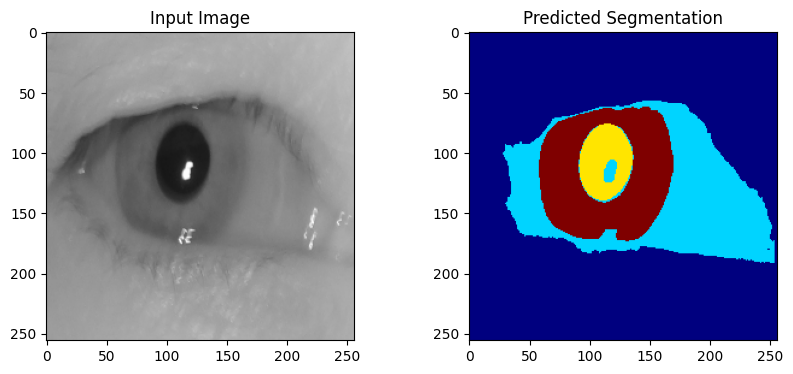

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load ONNX model
session = ort.InferenceSession("unet.onnx")

# Load and preprocess the input image
img_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png"
image = cv2.imread(img_path)
image = cv2.resize(image, (256, 256))
input_image = image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)  # shape: (1, 256, 256, 3)

# Check input shape expected by model
print("Expected input shape:", session.get_inputs()[0].shape)

# Run inference (no transpose)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
output = session.run([output_name], {input_name: input_image})[0]

# Convert output to predicted classes per pixel
predicted_classes = np.argmax(output[0], axis=2)  # axis=2 because output shape likely (1, 256, 256, num_classes)

# Visualize results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation")
plt.imshow(predicted_classes, cmap="jet")

plt.show()


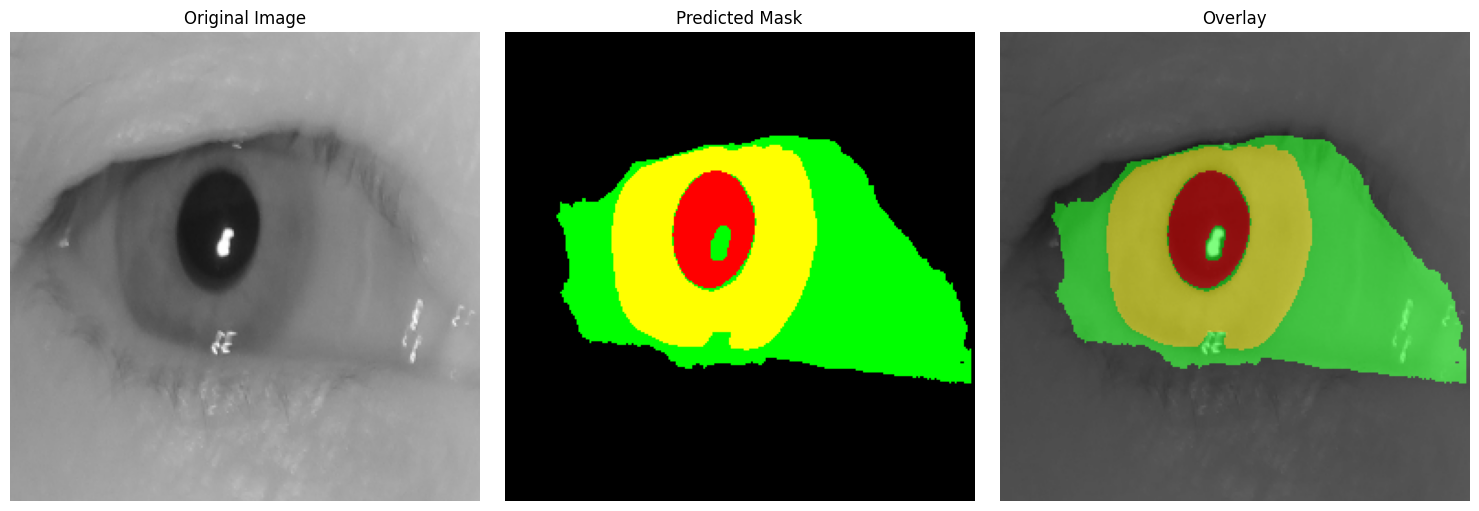

In [ ]:
import onnxruntime as ort
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define your class-to-color mapping (adjust colors as needed)
CLASS_COLORS = {
    0: (0, 0, 0),          # Background - black
    1: (0, 255, 0),        # Class 1 - green
    2: (255, 0, 0),        # Class 2 - blue
    3: (255, 255, 0)       # Class 3 - cyan
}

# Load ONNX model
session = ort.InferenceSession("unet.onnx")

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess image for ONNX inference."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Shape: (1, H, W, 3)
    return img

def predict_mask(image_path):
    """Predict segmentation mask for a given image path using ONNX."""
    img_input = preprocess_image(image_path)

    # Get input name for the ONNX model
    input_name = session.get_inputs()[0].name

    # Run inference (assuming model expects NHWC input)
    output_name = session.get_outputs()[0].name
    output = session.run([output_name], {input_name: img_input})[0]  # shape: (1, H, W, num_classes)

    # Get predicted class per pixel
    pred_mask = np.argmax(output[0], axis=-1)  # Shape: (H, W)
    return pred_mask

def decode_mask(mask):
    """Convert predicted mask (H, W) to RGB color mask."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

def overlay_mask_on_image(image_path, mask, alpha=0.5):
    """Overlay color mask on original image."""
    original = cv2.imread(image_path)
    original = cv2.resize(original, (256, 256))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    color_mask = decode_mask(mask)
    overlay = cv2.addWeighted(original_rgb, 1 - alpha, color_mask, alpha, 0)

    return original_rgb, color_mask, overlay

def predict_and_overlay(image_path):
    """Complete prediction and visualization pipeline."""
    pred_mask = predict_mask(image_path)
    original, color_mask, overlay = overlay_mask_on_image(image_path, pred_mask)

    # Display the result
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask")
    plt.imshow(color_mask)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔥 Run inference on a sample image
predict_and_overlay("/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png")


In [ ]:
import time
import numpy as np
import cv2
import tensorflow as tf
import onnxruntime as ort

# Load Keras model
keras_model = tf.keras.models.load_model("unet_multiclass_final_model.h5")

# Load ONNX model
onnx_session = ort.InferenceSession("unet.onnx")

def preprocess(image_path, target_size=(256,256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def keras_inference(image_path):
    img = preprocess(image_path)
    input_tensor = np.expand_dims(img, axis=0)  # (1, H, W, C)
    start = time.time()
    pred = keras_model.predict(input_tensor)
    end = time.time()
    pred_mask = np.argmax(pred[0], axis=-1)
    return pred_mask, end - start

def onnx_inference(image_path):
    img = preprocess(image_path)
    input_tensor = np.expand_dims(img, axis=0).astype(np.float32)  # (1, H, W, C)
    input_name = onnx_session.get_inputs()[0].name
    start = time.time()
    output = onnx_session.run(None, {input_name: input_tensor})[0]
    end = time.time()
    pred_mask = np.argmax(output[0], axis=-1)
    return pred_mask, end - start

# Run both inferences
image_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png"

keras_mask, keras_time = keras_inference(image_path)
onnx_mask, onnx_time = onnx_inference(image_path)

print(f"Keras inference time: {keras_time:.4f} seconds")
print(f"ONNX inference time: {onnx_time:.4f} seconds")

# Compare predictions (simple pixel-wise accuracy)
pixel_agreement = np.mean(keras_mask == onnx_mask)
print(f"Pixel-wise agreement between Keras and ONNX outputs: {pixel_agreement*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Keras inference time: 5.6342 seconds
ONNX inference time: 1.0997 seconds
Pixel-wise agreement between Keras and ONNX outputs: 100.00%


In [ ]:
import tensorflow as tf

# Load your Keras model
keras_model = tf.keras.models.load_model("unet_multiclass_final_model.h5")

# Convert to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
tflite_model = converter.convert()

# Save the converted model to disk
with open("unet.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model saved as unet.tflite")


Saved artifact at '/tmp/tmpwk0yhl8m'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None)
Captures:
  134035560730640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560732176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560731600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560732944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560732368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560733712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560733136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560734480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560733904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134035560735248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13403

In [ ]:
import tensorflow as tf

# Load your trained Keras model
model = tf.keras.models.load_model("unet_multiclass_final_model.h5")

# Create a TFLiteConverter from the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# (Optional) Optimization for smaller/faster model (post-training quantization)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the converted TFLite model to a file
with open("unet_multiclass_model.tflite", "wb") as f:
    f.write(tflite_model)

print("TFLite model conversion complete and saved as 'unet_multiclass_model.tflite'.")


Saved artifact at '/tmp/tmp6z4yej9t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 256, 256, 4), dtype=tf.float32, name=None)
Captures:
  134033652185424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652179472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652184656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652186384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652184848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652183504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652185040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652351056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652351632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134033652353744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13403

Expected input shape: [  1 256 256   3]


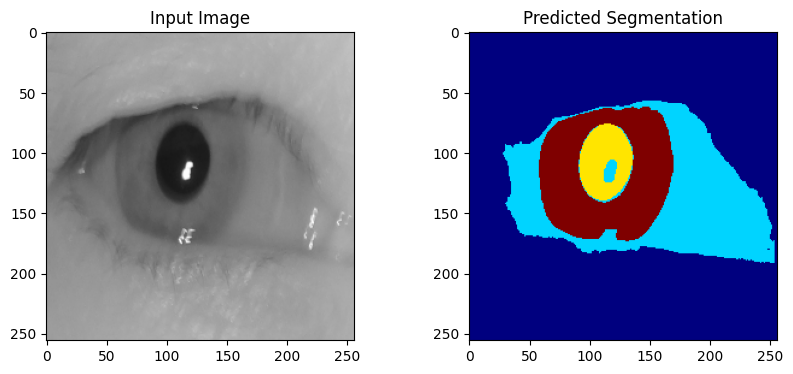

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="unet_multiclass_model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the input image
img_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png"
image = cv2.imread(img_path)
image = cv2.resize(image, (256, 256))
input_image = image.astype(np.float32) / 255.0
input_image = np.expand_dims(input_image, axis=0)  # Shape: (1, 256, 256, 3)

# Check input shape expected by TFLite model
print("Expected input shape:", input_details[0]['shape'])

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

# Run inference
interpreter.invoke()

# Get output tensor
output = interpreter.get_tensor(output_details[0]['index'])  # Shape: (1, 256, 256, num_classes)

# Convert output to predicted classes per pixel
predicted_classes = np.argmax(output[0], axis=2)  # axis=2 assuming output shape (1, H, W, num_classes)

# Visualize results
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Input Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title("Predicted Segmentation")
plt.imshow(predicted_classes, cmap="jet")

plt.show()


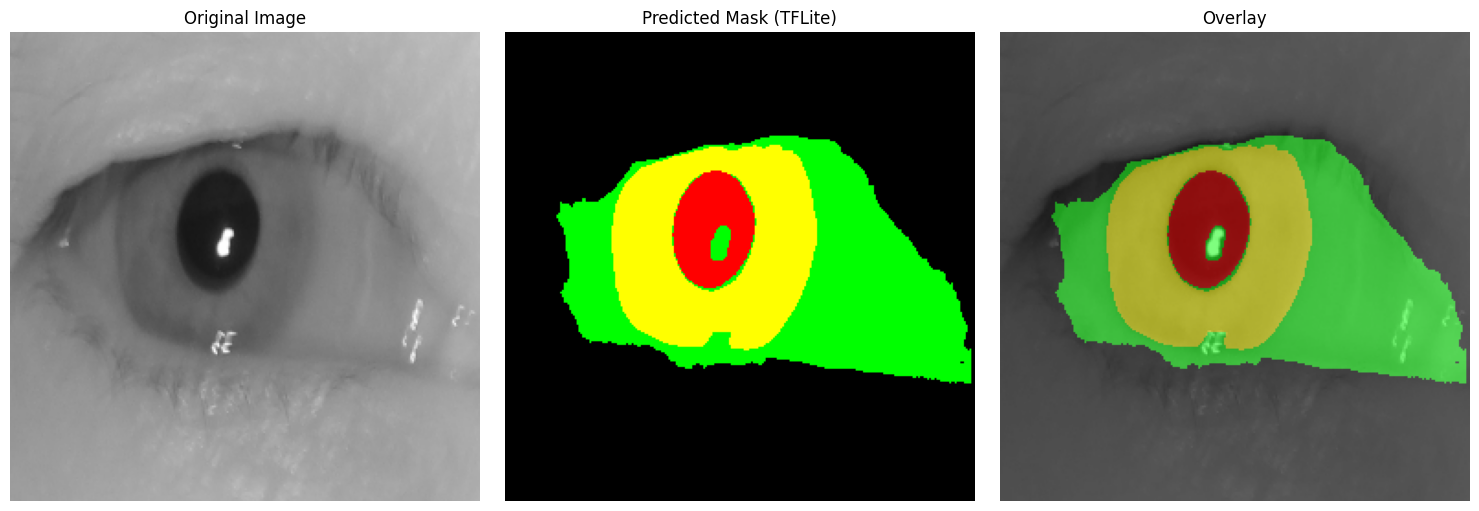

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="unet_multiclass_model.tflite")
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define class-color mapping (same as before)
CLASS_COLORS = {
    0: (0, 0, 0),          # Background - black
    1: (0, 255, 0),        # Class 1 - green
    2: (255, 0, 0),        # Class 2 - blue
    3: (255, 255, 0)       # Class 3 - cyan
}

def preprocess_image(image_path, target_size=(256, 256)):
    """Preprocess image for TFLite inference."""
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, axis=0)  # Shape: (1, H, W, 3)
    return img

def decode_mask(mask):
    """Convert predicted mask (H, W) to RGB color mask."""
    h, w = mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for class_id, color in CLASS_COLORS.items():
        color_mask[mask == class_id] = color
    return color_mask

def run_tflite_inference(image_path):
    input_data = preprocess_image(image_path)
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])  # Shape: (1, H, W, num_classes)
    pred_mask = np.argmax(output[0], axis=-1)  # (H, W)
    return pred_mask

def overlay_mask_on_image(image_path, mask, alpha=0.5):
    original = cv2.imread(image_path)
    original = cv2.resize(original, (256, 256))
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

    color_mask = decode_mask(mask)
    overlay = cv2.addWeighted(original_rgb, 1 - alpha, color_mask, alpha, 0)
    return original_rgb, color_mask, overlay

def predict_and_visualize_tflite(image_path):
    pred_mask = run_tflite_inference(image_path)
    original, color_mask, overlay = overlay_mask_on_image(image_path, pred_mask)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Predicted Mask (TFLite)")
    plt.imshow(color_mask)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(overlay)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# 🔥 Run on your image
image_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png"
predict_and_visualize_tflite(image_path)


Comparing the performance between all three Keras, ONNX and Tflite

In [ ]:
import time
import numpy as np
import cv2
import tensorflow as tf
import onnxruntime as ort

# Load Keras model
keras_model = tf.keras.models.load_model("unet_multiclass_final_model.h5")

# Load ONNX model
onnx_session = ort.InferenceSession("unet.onnx")

# Load TFLite model and allocate tensors
tflite_interpreter = tf.lite.Interpreter(model_path="unet.tflite")
tflite_interpreter.allocate_tensors()
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

def preprocess(image_path, target_size=(256,256)):
    img = cv2.imread(image_path)
    img = cv2.resize(img, target_size)
    img = img.astype(np.float32) / 255.0
    return img

def keras_inference(image_path):
    img = preprocess(image_path)
    input_tensor = np.expand_dims(img, axis=0)  # (1, H, W, C)
    start = time.time()
    pred = keras_model.predict(input_tensor)
    end = time.time()
    pred_mask = np.argmax(pred[0], axis=-1)
    return pred_mask, end - start

def onnx_inference(image_path):
    img = preprocess(image_path)
    input_tensor = np.expand_dims(img, axis=0).astype(np.float32)  # (1, H, W, C)
    input_name = onnx_session.get_inputs()[0].name
    start = time.time()
    output = onnx_session.run(None, {input_name: input_tensor})[0]
    end = time.time()
    pred_mask = np.argmax(output[0], axis=-1)
    return pred_mask, end - start

def tflite_inference(image_path):
    img = preprocess(image_path)
    input_data = np.expand_dims(img, axis=0).astype(np.float32)  # (1, H, W, C)
    tflite_interpreter.set_tensor(input_details[0]['index'], input_data)
    start = time.time()
    tflite_interpreter.invoke()
    end = time.time()
    output_data = tflite_interpreter.get_tensor(output_details[0]['index'])
    pred_mask = np.argmax(output_data[0], axis=-1)
    return pred_mask, end - start

# Run all inferences on the same image
image_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_1_1_2_33_000.png"

keras_mask, keras_time = keras_inference(image_path)
onnx_mask, onnx_time = onnx_inference(image_path)
tflite_mask, tflite_time = tflite_inference(image_path)

print(f"Keras inference time: {keras_time:.4f} seconds")
print(f"ONNX inference time: {onnx_time:.4f} seconds")
print(f"TFLite inference time: {tflite_time:.4f} seconds")

# Compare predictions (pixel-wise accuracy)
keras_onnx_agreement = np.mean(keras_mask == onnx_mask)
keras_tflite_agreement = np.mean(keras_mask == tflite_mask)
onnx_tflite_agreement = np.mean(onnx_mask == tflite_mask)

print(f"Pixel-wise agreement between Keras and ONNX outputs: {keras_onnx_agreement*100:.2f}%")
print(f"Pixel-wise agreement between Keras and TFLite outputs: {keras_tflite_agreement*100:.2f}%")
print(f"Pixel-wise agreement between ONNX and TFLite outputs: {onnx_tflite_agreement*100:.2f}%")


/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Keras inference time: 1.2587 seconds
ONNX inference time: 0.7486 seconds
TFLite inference time: 1.5066 seconds
Pixel-wise agreement between Keras and ONNX outputs: 100.00%
Pixel-wise agreement between Keras and TFLite outputs: 100.00%
Pixel-wise agreement between ONNX and TFLite outputs: 100.00%


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


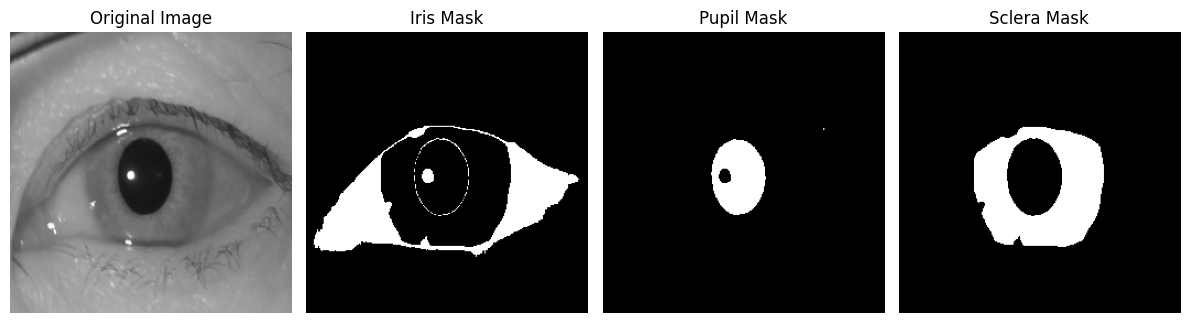

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# --- Load Keras Model ---
model = tf.keras.models.load_model("/content/unet_multiclass_final_model.h5", compile=False)

# --- Load and Preprocess Image ---
img_path = "/content/dataset/IRIS + PUPIL + EYE/val/image/0193_2_1_2_53_005.png"
original_img = cv2.imread(img_path)
img_resized = cv2.resize(original_img, (256, 256))
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

input_tensor = img_rgb.astype(np.float32) / 255.0
input_tensor = np.expand_dims(input_tensor, axis=0)  # Shape: (1, 256, 256, 3)

# --- Predict ---
predictions = model.predict(input_tensor)
predicted_mask = np.argmax(predictions[0], axis=-1)

# --- Generate Separate Masks ---
iris_mask = (predicted_mask == 1).astype(np.uint8) * 255
pupil_mask = (predicted_mask == 2).astype(np.uint8) * 255
sclera_mask = (predicted_mask == 3).astype(np.uint8) * 255

# --- Display Results ---
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(img_rgb)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(iris_mask, cmap='gray')
plt.title("Iris Mask")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(pupil_mask, cmap='gray')
plt.title("Pupil Mask")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(sclera_mask, cmap='gray')
plt.title("Sclera Mask")
plt.axis('off')

plt.tight_layout()
plt.show()
